In [1]:
import pandas as pd
from finta import TA
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
#yahoo finance stock data (for longer timeframe)

#Import data from Yahoo Finance
def stock_df(ticker, start, end):
    stock = yf.Ticker(ticker)
    stock_df = stock.history(start = start, end = end)
    return stock_df

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('today')
                     
spy_df = stock_df('SPY', start, end)

#Check the lenth of data
len(spy_df)

1771

In [3]:
#Find the daily return of the stock in percentage

# spy_df["Monetary Gain"] = spy_df["Close"].diff()
spy_df['Actual Return'] = spy_df["Close"].pct_change()

#Buy signal for price change >1%
#Sell signal for price change <0%
#Hold Signal for price change is between 0% and 1%
spy_df.loc[(spy_df['Actual Return']*100 > 1), 'Return Direction'] = 1
spy_df.loc[(spy_df['Actual Return']*100  < 1), 'Return Direction'] = 0
spy_df.loc[(spy_df['Actual Return']*100 < 0), "Return Direction"] = -1


# spy_df['Trades'] = np.abs(spy_df['Trading Signal'].diff())
# spy_df['Strategy Returns'] = spy_df['Actual Return'] * spy_df['Trading Signal'].shift()



#display SPY
spy_df.dropna(inplace= True)

display(spy_df.head(10))
display(spy_df.tail(10))

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Actual Return,Return Direction
Date,,,,,,,,,
2015-01-05,179.236494,179.412067,176.760883,177.085693,169632600,0.0,0,-0.018060,-1.0
2015-01-06,177.410561,177.963629,174.575016,175.417786,209151400,0.0,0,-0.009419,-1.0
2015-01-07,176.822372,177.963617,176.348323,177.603683,125346700,0.0,0,0.012461,1.0
2015-01-08,179.096104,180.983552,179.078556,180.755295,147217800,0.0,0,0.017745,1.0
2015-01-09,181.194228,181.211789,178.657158,179.306793,158567300,0.0,0,-0.008014,-1.0
2015-01-12,179.447236,179.614035,177.261313,177.902161,144396100,0.0,0,-0.007834,-1.0
2015-01-13,179.192631,180.386547,176.023488,177.401764,214553300,0.0,0,-0.002813,-1.0
2015-01-14,175.268541,176.541476,174.320443,176.330780,192991100,0.0,0,-0.006037,-1.0
2015-01-15,177.006688,177.340272,174.592521,174.715424,176613900,0.0,0,-0.009161,-1.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Actual Return,Return Direction
Date,,,,,,,,,
2021-12-30,477.929993,479.000000,475.670013,476.160004,55329000,0.0,0,-0.002765,-1.0
2021-12-31,475.640015,476.859985,474.670013,474.959991,65210500,0.0,0,-0.002520,-1.0
2022-01-03,476.299988,477.850006,473.850006,477.709991,72668200,0.0,0,0.005790,0.0
2022-01-04,479.220001,479.980011,475.579987,477.549988,71178700,0.0,0,-0.000335,-1.0
2022-01-05,477.160004,477.980011,468.279999,468.380005,104538900,0.0,0,-0.019202,-1.0
2022-01-06,467.890015,470.820007,465.429993,467.940002,86858900,0.0,0,-0.000939,-1.0
2022-01-07,467.950012,469.200012,464.649994,466.089996,85064800,0.0,0,-0.003954,-1.0
2022-01-10,462.700012,465.739990,456.600006,465.510010,119362000,0.0,0,-0.001244,-1.0
2022-01-11,465.230011,469.850006,462.049988,469.750000,74303100,0.0,0,0.009108,0.0


In [4]:
#Adding Technical indicators

spy_technical_indicators = pd.DataFrame()

spy_technical_indicators["close"] = spy_df["Close"]
spy_technical_indicators["Actual Return"] = spy_df["Actual Return"]
spy_technical_indicators["Signal"] = spy_df["Return Direction"]



#Creating Volume Weighted Average Price 'VWAP'  -- Trend Indicator
spy_technical_indicators['VWAP'] = TA.VWAP(spy_df)
spy_technical_indicators["VWAP Evaluation"] = "Hold"
spy_technical_indicators.loc[spy_technical_indicators["VWAP"] < spy_technical_indicators["close"], 'VWAP Evaluation'] = "Sell"
spy_technical_indicators.loc[spy_technical_indicators["VWAP"] > spy_technical_indicators["close"], 'VWAP Evaluation'] = "Buy"

spy_technical_indicators["VWAP Lag"] = spy_technical_indicators["VWAP Evaluation"].shift(1)

for index, row in spy_technical_indicators.iterrows():
    if (spy_technical_indicators.loc[index, "VWAP Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "VWAP Lag"] == "Sell"):
            spy_technical_indicators.loc[index, "VWAP Evaluation"] = "VWAP Bearish Signal"
    if (spy_technical_indicators.loc[index, "VWAP Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "VWAP Lag"] == "Buy"):
            spy_technical_indicators.loc[index, "VWAP Evaluation"] = "VWAP Buillish Signal"

spy_technical_indicators.drop(columns = ["VWAP Lag"], inplace = True)



#Creating Exponential Moving Average 'EMA' short(9-days) and long(70-days) for DMAC trading algorithm -- Trend Indicator
spy_technical_indicators['EMA_short'] = TA.EMA(spy_df, 9)
spy_technical_indicators['EMA_long'] = TA.EMA(spy_df, 70)
spy_technical_indicators["DMAC Evaluation"] = "Hold"
spy_technical_indicators.loc[spy_technical_indicators["EMA_short"] < spy_technical_indicators["EMA_long"], 'DMAC Evaluation'] = "Buy"
spy_technical_indicators.loc[spy_technical_indicators["EMA_short"] > spy_technical_indicators["EMA_long"], 'DMAC Evaluation'] = "Sell"

spy_technical_indicators["DMAC Lag"] = spy_technical_indicators["DMAC Evaluation"].shift(1)

for index, row in spy_technical_indicators.iterrows():
    if (spy_technical_indicators.loc[index, "DMAC Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "DMAC Lag"] == "Sell"):
            spy_technical_indicators.loc[index, "DMAC Evaluation"] = "DMAC Bearish Signal"
    if (spy_technical_indicators.loc[index, "DMAC Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "DMAC Lag"] == "Buy"):
            spy_technical_indicators.loc[index, "DMAC Evaluation"] = "DMAC Buillish Signal"

spy_technical_indicators.drop(columns = ["DMAC Lag"], inplace = True)



#Creating Bollinger Bands 'BBANDS'  -- Volatility Indicator
bbands_df = TA.BBANDS(spy_df)
spy_technical_indicators = pd.concat([spy_technical_indicators, bbands_df], axis=1)
spy_technical_indicators["BBbands Evaluation"] = "Hold"
spy_technical_indicators.loc[spy_technical_indicators["BB_UPPER"] < spy_technical_indicators["close"], 'BBbands Evaluation'] = "Sell"
spy_technical_indicators.loc[spy_technical_indicators["BB_LOWER"] > spy_technical_indicators["close"], 'BBbands Evaluation'] = "Buy"

spy_technical_indicators["BBbands Lag"] = spy_technical_indicators["BBbands Evaluation"].shift(1)

for index, row in spy_technical_indicators.iterrows():
    if (spy_technical_indicators.loc[index, "BBbands Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "BBbands Lag"] == "Sell"):
            spy_technical_indicators.loc[index, "BBbands Evaluation"] = "BBbands Bearish Signal"
    if (spy_technical_indicators.loc[index, "BBbands Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "BBbands Lag"] == "Buy"):
            spy_technical_indicators.loc[index, "BBbands Evaluation"] = "BBbands Buillish Signal"

spy_technical_indicators.drop(columns = ["BBbands Lag"], inplace = True)



#Creating Elder's Force Index 'EFI'  -- Volatility Indicator
spy_technical_indicators['EFI'] = TA.EFI(spy_df)
spy_technical_indicators["EFI Evaluation"] = "Hold"
spy_technical_indicators.loc[spy_technical_indicators["EFI"] < 0, 'EFI Evaluation'] = "Buy"
spy_technical_indicators.loc[spy_technical_indicators["EFI"] > 0, 'EFI Evaluation'] = "Sell"

spy_technical_indicators["EFI Lag"] = spy_technical_indicators["EFI Evaluation"].shift(1)

for index, row in spy_technical_indicators.iterrows():
    if (spy_technical_indicators.loc[index, "EFI Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "EFI Lag"] == "Sell"):
            spy_technical_indicators.loc[index, "EFI Evaluation"] = "EFI Bearish Signal"
    if (spy_technical_indicators.loc[index, "EFI Evaluation"] == "Hold" and spy_technical_indicators.loc[index, "EFI Lag"] == "Buy"):
            spy_technical_indicators.loc[index, "EFI Evaluation"] = "EFI Buillish Signal"

spy_technical_indicators.drop(columns = ["EFI Lag"], inplace = True)
spy_technical_indicators.dropna(inplace=True)


display(spy_technical_indicators.head(10))
display(spy_technical_indicators.tail(10))

,close,Actual Return,Signal,VWAP,VWAP Evaluation,EMA_short,EMA_long,DMAC Evaluation,BB_UPPER,BB_MIDDLE,BB_LOWER,BBbands Evaluation,EFI,EFI Evaluation
Date,,,,,,,,,,,,,,
2015-02-02,177.261307,0.012384,1.0,177.454247,Buy,177.330493,177.673940,Buy,181.333040,177.688839,174.044638,Hold,-9.392037e+06,Buy
2015-02-03,179.824738,0.014461,1.0,177.517415,Sell,177.833986,177.808214,Sell,181.578801,177.825791,174.072782,Hold,3.968579e+07,Sell
2015-02-04,179.139938,-0.003808,-1.0,177.588655,Sell,178.097118,177.888599,Sell,181.628815,178.011899,174.394982,Hold,2.010847e+07,Sell
2015-02-05,180.948395,0.010095,1.0,177.671177,Sell,178.670759,178.067534,Sell,182.019006,178.179134,174.339263,Hold,4.332365e+07,Sell
2015-02-06,180.447998,-0.002765,-1.0,177.775822,Sell,179.027894,178.202646,Sell,181.962477,178.163770,174.365062,Hold,2.770005e+07,Sell
2015-02-09,179.640366,-0.004476,-1.0,177.822177,Sell,179.150852,178.281981,Sell,182.003139,178.180448,174.357757,Hold,1.332436e+07,Sell
2015-02-10,181.554108,0.010653,1.0,177.901254,Sell,179.632961,178.457792,Sell,182.468213,178.363046,174.257878,Hold,3.823957e+07,Sell
2015-02-11,181.659485,0.000580,0.0,177.983346,Sell,180.039248,178.625531,Sell,182.906604,178.575932,174.245259,Hold,3.407227e+07,Sell
2015-02-12,183.406479,0.009617,0.0,178.099871,Sell,180.713999,178.870085,Sell,183.628544,178.929716,174.230889,Hold,5.385755e+07,Sell


,close,Actual Return,Signal,VWAP,VWAP Evaluation,EMA_short,EMA_long,DMAC Evaluation,BB_UPPER,BB_MIDDLE,BB_LOWER,BBbands Evaluation,EFI,EFI Evaluation
Date,,,,,,,,,,,,,,
2021-12-30,476.160004,-0.002765,-1.0,254.571598,Sell,471.867232,457.534793,Sell,481.084370,465.877753,450.671135,Hold,3.626010e+07,Sell
2021-12-31,474.959991,-0.002520,-1.0,254.661008,Sell,472.485784,458.025643,Sell,481.780892,466.835818,451.890745,Hold,1.990103e+07,Sell
2022-01-03,477.709991,0.005790,0.0,254.760996,Sell,473.530626,458.580132,Sell,482.051323,468.129687,454.208052,Hold,4.560624e+07,Sell
2022-01-04,477.549988,-0.000335,-1.0,254.859392,Sell,474.334498,459.114494,Sell,482.672224,469.147997,455.623769,Hold,3.746409e+07,Sell
2022-01-05,468.380005,-0.019202,-1.0,254.999758,Sell,473.143599,459.375494,Sell,482.713597,469.234967,455.756337,Hold,-1.048336e+08,Buy
2022-01-06,467.940002,-0.000939,-1.0,255.114373,Sell,472.102880,459.616748,Sell,482.715462,469.238156,455.760850,Hold,-9.531713e+07,Buy
2022-01-07,466.089996,-0.003954,-1.0,255.225755,Sell,470.900303,459.799093,Sell,482.700883,469.306789,455.912694,Hold,-1.041819e+08,Buy
2022-01-10,465.510010,-0.001244,-1.0,255.378873,Sell,469.822245,459.959964,Sell,482.629242,469.127692,455.626142,Hold,-9.918852e+07,Buy
2022-01-11,469.750000,0.009108,0.0,255.476188,Sell,469.807796,460.235740,Sell,482.726189,469.368362,456.010536,Hold,-4.001239e+07,Buy


In [5]:
#Drop unnecessary variables
spy_technical_indicators.drop(columns = ["close"], inplace = True)
spy_technical_indicators.drop(columns = ["Signal"], inplace = True)

spy_technical_indicators

,Actual Return,VWAP,VWAP Evaluation,EMA_short,EMA_long,DMAC Evaluation,BB_UPPER,BB_MIDDLE,BB_LOWER,BBbands Evaluation,EFI,EFI Evaluation
Date,,,,,,,,,,,,
2015-02-02,0.012384,177.454247,Buy,177.330493,177.673940,Buy,181.333040,177.688839,174.044638,Hold,-9.392037e+06,Buy
2015-02-03,0.014461,177.517415,Sell,177.833986,177.808214,Sell,181.578801,177.825791,174.072782,Hold,3.968579e+07,Sell
2015-02-04,-0.003808,177.588655,Sell,178.097118,177.888599,Sell,181.628815,178.011899,174.394982,Hold,2.010847e+07,Sell
2015-02-05,0.010095,177.671177,Sell,178.670759,178.067534,Sell,182.019006,178.179134,174.339263,Hold,4.332365e+07,Sell
2015-02-06,-0.002765,177.775822,Sell,179.027894,178.202646,Sell,181.962477,178.163770,174.365062,Hold,2.770005e+07,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,-0.000939,255.114373,Sell,472.102880,459.616748,Sell,482.715462,469.238156,455.760850,Hold,-9.531713e+07,Buy
2022-01-07,-0.003954,255.225755,Sell,470.900303,459.799093,Sell,482.700883,469.306789,455.912694,Hold,-1.041819e+08,Buy
2022-01-10,-0.001244,255.378873,Sell,469.822245,459.959964,Sell,482.629242,469.127692,455.626142,Hold,-9.918852e+07,Buy


In [6]:
#Define categorical variables
categorical_variables = list(spy_technical_indicators.dtypes[spy_technical_indicators.dtypes == "object"].index)

# Display the categorical variables list
categorical_variables

['VWAP Evaluation', 'DMAC Evaluation', 'BBbands Evaluation', 'EFI Evaluation']

In [7]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse= False)
encoded_data = enc.fit_transform(spy_technical_indicators[categorical_variables])

encoded_df = pd.DataFrame(encoded_data, columns = enc.get_feature_names(categorical_variables), index = spy_technical_indicators.index)

encoded_df = pd.concat([encoded_df, spy_technical_indicators.drop(columns = categorical_variables)], axis = 1)
encoded_df

,VWAP Evaluation_Buy,VWAP Evaluation_Sell,DMAC Evaluation_Buy,DMAC Evaluation_Sell,BBbands Evaluation_BBbands Bearish Signal,BBbands Evaluation_BBbands Buillish Signal,BBbands Evaluation_Buy,BBbands Evaluation_Hold,BBbands Evaluation_Sell,EFI Evaluation_Buy,EFI Evaluation_Sell,Actual Return,VWAP,EMA_short,EMA_long,BB_UPPER,BB_MIDDLE,BB_LOWER,EFI
Date,,,,,,,,,,,,,,,,,,,
2015-02-02,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.012384,177.454247,177.330493,177.673940,181.333040,177.688839,174.044638,-9.392037e+06
2015-02-03,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.014461,177.517415,177.833986,177.808214,181.578801,177.825791,174.072782,3.968579e+07
2015-02-04,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.003808,177.588655,178.097118,177.888599,181.628815,178.011899,174.394982,2.010847e+07
2015-02-05,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.010095,177.671177,178.670759,178.067534,182.019006,178.179134,174.339263,4.332365e+07
2015-02-06,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.002765,177.775822,179.027894,178.202646,181.962477,178.163770,174.365062,2.770005e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.000939,255.114373,472.102880,459.616748,482.715462,469.238156,455.760850,-9.531713e+07
2022-01-07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.003954,255.225755,470.900303,459.799093,482.700883,469.306789,455.912694,-1.041819e+08
2022-01-10,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.001244,255.378873,469.822245,459.959964,482.629242,469.127692,455.626142,-9.918852e+07


In [8]:
#define training and testing data, and then scaler them
X = encoded_df.drop(columns = ["Actual Return"])
y = encoded_df["Actual Return"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [9]:
#define neural network 

neural = Sequential()

number_input_features = len(X.columns)
hidden_nodes_layer1 =  (number_input_features + 1) // 2 
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) // 2
hidden_nodes_layer3 = (hidden_nodes_layer2 + 1) // 2

neural.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="elu"))
neural.add(Dense(units=hidden_nodes_layer2, activation="elu"))
neural.add(Dense(units=hidden_nodes_layer3, activation="elu"))
neural.add(Dense(units=1, activation="linear"))

neural.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 171       
                                                                 
 dense_1 (Dense)             (None, 5)                 50        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


In [10]:
# opt = tf.keras.optimizers.SGD(lr=0.01)

#complie neural network and fit
neural.compile(loss = "mse", optimizer = "adam",  metrics = ["mse"])

model = neural.fit(X_train_scaled, y_train, epochs = 500)

Epoch 1/500
42/42 [==============================] - 0s 580us/step - loss: 0.2690 - mse: 0.2690
Epoch 2/500
42/42 [==============================] - 0s 537us/step - loss: 0.0555 - mse: 0.0555
Epoch 3/500
42/42 [==============================] - 0s 585us/step - loss: 0.0225 - mse: 0.0225
Epoch 4/500
42/42 [==============================] - 0s 537us/step - loss: 0.0154 - mse: 0.0154
Epoch 5/500
42/42 [==============================] - 0s 537us/step - loss: 0.0113 - mse: 0.0113
Epoch 6/500
42/42 [==============================] - 0s 634us/step - loss: 0.0089 - mse: 0.0089
Epoch 7/500
42/42 [==============================] - 0s 512us/step - loss: 0.0071 - mse: 0.0071
Epoch 8/500
42/42 [==============================] - 0s 585us/step - loss: 0.0057 - mse: 0.0057
Epoch 9/500
42/42 [==============================] - 0s 537us/step - loss: 0.0047 - mse: 0.0047
Epoch 10/500
42/42 [==============================] - 0s 561us/step - loss: 0.0039 - mse: 0.0039
Epoch 11/500
42/42 [===================

In [11]:
#Use training data to predict

# Y_prediction = (neural.predict(X_train_scaled) > 0.5).astype("int32")
Y_prediction = neural.predict(X_train_scaled)
Y_prediction = Y_prediction.squeeze()

results = pd.DataFrame( {"Predictions": Y_prediction, "Actual": y_train})
display(results)

#Evaluate the model
model_loss, model_accuracy = neural.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss}, MSE: {model_accuracy}")

,Predictions,Actual
Date,,
2020-10-21,0.000574,-0.001893
2017-11-20,0.000582,0.001706
2015-07-10,0.009772,0.012592
2020-11-25,0.004276,-0.001542
2017-04-21,0.002464,-0.003187
...,...,...
2017-12-01,0.007099,-0.002075
2018-09-05,0.000017,-0.002692
2019-06-11,0.005342,-0.000242


42/42 - 0s - loss: 6.0414e-05 - mse: 6.0414e-05 - 106ms/epoch - 3ms/step
Loss: 6.0414477047743276e-05, MSE: 6.0414477047743276e-05


In [12]:
#Use testing data to predict
Y_test_prediction = neural.predict(X_test_scaled) 
Y_test_prediction = Y_test_prediction.squeeze()

test_results = pd.DataFrame( {"Predictions": Y_prediction, "Actual": y_train})

#Evaluate the model
model_loss, model_accuracy = neural.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, MSE: {model_accuracy}")

14/14 - 0s - loss: 1.1053e-04 - mse: 1.1053e-04 - 20ms/epoch - 1ms/step
Loss: 0.00011053433263441548, MSE: 0.00011053433263441548


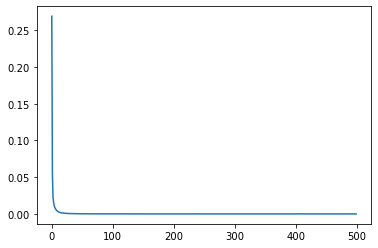

In [13]:
#Plot the neural network

plt.plot(model.history["loss"])

<AxesSubplot:xlabel='Date'>

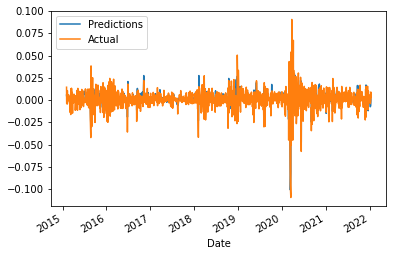

In [14]:
#Save the neural network

neural.save(Path("Files/Momentum_Indicators.h5"))

test_results.plot()